In [1]:
import pandas as pd
import math
from sklearn.cluster import MiniBatchKMeans
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np

In [2]:
path_earthquake = './data_earthquake.csv'
path_well = './total_pro.csv'
data_earthquake = pd.read_csv(path_earthquake)
data_well = pd.read_csv(path_well)

In [3]:
data_earthquake = data_earthquake[['#YYY/MM/DD','MAGNITUDE','LAT','LON','DEPTH']]
data_earthquake.columns = ['Date','Magnitude','Latitude','Longitude','Depth']

In [4]:
data_earthquake.loc[:,'Date'] = pd.to_datetime(data_earthquake['Date'],format = '%Y/%m/%d')
data_earthquake = data_earthquake[['Date','Magnitude','Latitude','Longitude','Depth']]

In [5]:
def timeChangeForEarthquake(data_earthquake):
    dataSet = data_earthquake
    dataSet.loc[:,'Date'] = pd.to_datetime(dataSet['Date'],format = '%Y/%m/%d')
    dataSet.loc[:,'Year'] = dataSet['Date'].dt.strftime('%Y')
    dataSet['Year'] = dataSet['Year'].astype('int')
    dataSet.loc[:,'Month'] = dataSet['Date'].dt.strftime('%m')
    dataSet['Month'] = dataSet['Month'].astype('int')
    dataSet['Time'] = 12*(dataSet['Year']-1930) + (dataSet['Month'] - 1)
    return dataSet[['Date','Latitude','Longitude','Magnitude','Time','Depth']]

def timeChangeForWell(data_well):
    dataSet = data_well
    dataSet.loc[:,'Date'] = pd.to_datetime(dataSet['Date'],format = '%Y/%m/%d')
    dataSet.loc[:,'Year'] = dataSet['Date'].dt.strftime('%Y')
    dataSet['Year'] = dataSet['Year'].astype('int')
    dataSet.loc[:,'Month'] = dataSet['Date'].dt.strftime('%m')
    dataSet['Month'] = dataSet['Month'].astype('int')
    dataSet['Time'] = 12*(dataSet['Year']-1930) + (dataSet['Month'] - 1)
    return dataSet[['Date','Latitude','Longitude','Production (bbl)','Time']]

In [6]:
dw = timeChangeForWell(data_well)
de = timeChangeForEarthquake(data_earthquake)

dw = dw[['Latitude', 'Longitude', 'Production (bbl)', 'Time']]
de = de[de['Time'] >= 564].reset_index()
de = de[['Latitude', 'Longitude', 'Magnitude', 'Depth', 'Time']]

In [7]:
def upscaleWell(k,data):
    location = data[['Latitude','Longitude']]
    model = MiniBatchKMeans(n_clusters = k, random_state=9)
    model.fit(location)
    r1 = pd.DataFrame(model.cluster_centers_)
    r = pd.concat([data, pd.Series(model.labels_, index = location.index)], axis = 1)  
    m = r.rename(columns = {0:'label_cluster'})
    
    for i in range(k):
        r.loc[r[0]==i,'Latitude'] = r1.at[i,0]
        r.loc[r[0]==i,'Longitude'] = r1.at[i,1]
    
    f = r.rename(columns = {0:'label_cluster'}).groupby(['Time','Latitude','Longitude','label_cluster']).agg('sum').reset_index()
    return r1,m,f

if __name__ == '__main__':
    t1 = time.time()
    k_well = 50
    p1,p2,p3 = upscaleWell(k_well, dw)
    t2 = time.time()
    print('The running time of upscaling for well data is {:0}s'.format(t2-t1))

The running time of upscaling for well data is 3.5413658618927s


  0%|          | 0/50 [00:00<?, ?it/s]

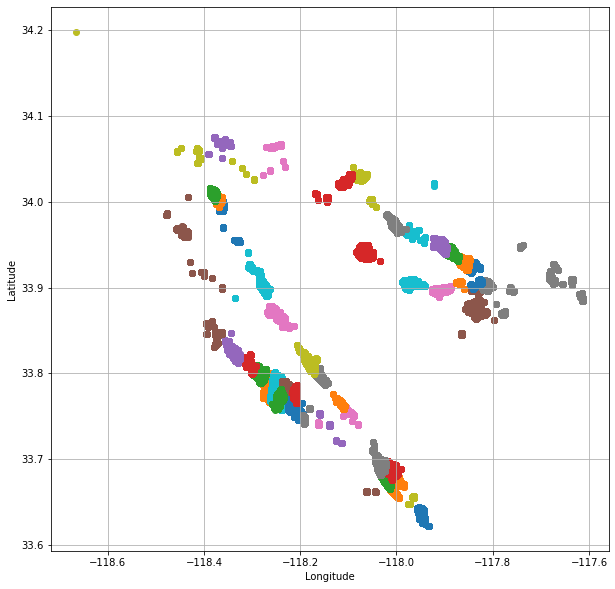

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
for i in tqdm(p3['label_cluster'].value_counts().keys().tolist()):
    plt.scatter(p2[p2['label_cluster'] == i].loc[:, 'Longitude'], p2[p2['label_cluster'] == i].loc[:, 'Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [9]:
def influenceRadius(data_well):
    max_radius = 10
    min_radius = 1
    dataSet = data_well
    dataSet.loc[:, 'influence (km)'] = (max_radius - min_radius) * (abs(dataSet.loc[:,'Production (bbl)']) - min(abs(dataSet.loc[:,'Production (bbl)']))) / (max(abs(dataSet.loc[:,'Production (bbl)'])) - min(abs(dataSet.loc[:,'Production (bbl)']))) + min_radius
    return data_well

In [10]:
wd = influenceRadius(p3[p3['Production (bbl)']!=0])
ed = de

In [11]:
def distance_data(data_well, lat_earthquake, lon_earthquake):
    r = 6371
    i1 = (data_well['Latitude'] / 180) * math.pi
    j1 = (data_well['Longitude'] / 180) * math.pi
    i2 = (lat_earthquake / 180) * math.pi
    j2 = (lon_earthquake / 180) * math.pi
    data_well['distance'] = 2 * r * ((((( data_well['Latitude'] / 180 * math.pi - lat_earthquake / 180 * math.pi )  / 2).apply(math.sin)) ** 2 + math.cos((lat_earthquake / 180) * math.pi) * ((data_well['Latitude'] / 180) * math.pi).apply(math.cos) * ((((data_well['Longitude'] / 180) * math.pi - (lon_earthquake / 180) * math.pi) / 2).apply(math.sin)) ** 2).apply(math.sqrt)).apply(math.asin)
    return data_well

In [12]:
def labelEarthquake(data_well, data_earthquake):
    influence_time = 12 * 5 #month
    label_earthquake = []
    for i in tqdm(data_earthquake[['Time', 'Latitude', 'Longitude']].values.tolist()):
        dataSet = data_well[(data_well['Time'] < i[0]) & (data_well['Time'] >= (i[0] - influence_time))]
        # label 0 means the earthquake is not influenced by injection or production
        distance_data(dataSet, i[1], i[2])
        if len(dataSet[dataSet['distance']<=dataSet['influence (km)']]) > 0:
            label_earthquake.append(1)
        else:
            label_earthquake.append(0)
        
    return label_earthquake

In [ ]:
label_earthquake = labelEarthquake(wd, ed)

  0%|          | 0/809553 [00:00<?, ?it/s]

In [ ]:
ed['label_earthquake'] = label_earthquake

In [ ]:
def getFeatureLabel1(data_well, data_earthquake):
    influence_time = 12 * 5 #month
    feature = []
    for i in tqdm(data_well[['Time','Latitude','Longitude','influence (km)']].values.tolist()):
        f = []
        dataSet = data_earthquake[(data_earthquake['Time'] > i[0]) & (data_earthquake['Time'] <= (i[0] + influence_time))]
        dataSet = distance_data(dataSet, i[1], i[2])
        if len(dataSet[dataSet['distance']<=i[3]]) > 0:
            #magnitude, depth, frequency, label
            f.append(dataSet[dataSet['distance']<=i[3]]['Magnitude'].mean())
            f.append(dataSet[dataSet['distance']<=i[3]]['Depth'].mean())
            f.append(len(dataSet[dataSet['distance']<=i[3]]))
            f.append(1)
            feature.append(f)
    return feature

In [ ]:
def getFeatureLabel0(data_earthquake, k):
    feature = []
    location = data_earthquake[['Latitude','Longitude']]
    model = MiniBatchKMeans(n_clusters = k, random_state=9)
    model.fit(location)
    r = pd.concat([data_earthquake, pd.Series(model.labels_, index = location.index)], axis = 1)
    for j in tqdm(set(list(model.labels_))):
        f=[]
        f.append(r[r[0] == j]['Magnitude'].mean())
        f.append(r[r[0] == j]['Depth'].mean())
        f.append(len(r[r[0] == j]))
        f.append(0)
        feature.append(f)

    return feature

In [ ]:
f1 = getFeatureLabel1(wd,ed[ed['label_earthquake']==1])

In [ ]:
f0 = getFeatureLabel0(ed[ed['label_earthquake']==0], 30000)

In [ ]:
feature = f1 + f0

In [ ]:
featureSet = pd.DataFrame(feature).dropna(axis=0)

In [ ]:
from collections import Counter

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import seaborn as sns

In [ ]:
x = np.array(np.array(featureSet)[0:, :-1], dtype='float')
y = np.array(np.array(featureSet)[0:, -1], dtype='int')

In [ ]:
Counter(y)

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.75,random_state=9)

In [ ]:
model = RandomForestRegressor(n_estimators=1000, min_samples_split=2,random_state=9)
model.fit(train_x, train_y)

In [ ]:
pred_test_y = model.predict(test_x)

In [ ]:
print(r2_score(test_y, pred_test_y))

In [ ]:
corr = pd.DataFrame(x, columns=['magnitude', 'depth', 'frequency']).corr()

In [ ]:
sns.heatmap(corr,cmap='Blues',annot=True)
#plt.title("test")
plt.savefig("1.png", transparent=True)

In [ ]:
help(plt.savefig)